In [1]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

In [2]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

## X and y arrays for sklearn models

In [3]:
X_all = StandardScaler().fit_transform(data[data_cols].T)
X_only_conv = StandardScaler().fit_transform(data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T)
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = StandardScaler().fit_transform(data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T)

# Generate y 
# ['normal', 'impaired', 'diabetic']
y_3class = fg.set_index('combined_col_name')['glucose_tolerance']
# [0, 1, 2]
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})
# random/fasted blood glucoose
y_cont = fg.set_index('combined_col_name')['bg']
# ogtt result
ogtt_dict = animal_phenotypes.set_index('animal').to_dict()['OGTT (AUC)']
y_ogtt = fg[['combined_col_name', 'animal']].set_index('combined_col_name')['animal'].map(ogtt_dict)

## StatsModels Least Squares with regularization


In [4]:
# sm_ols = sm.OLS(exog=X_only_signf, endog=y_continuous)
# sm_fit = sm_ols.fit_regularized(L1_wt=0.5, maxiter=10000)

In [5]:
# plt.hist(sm_fit.params)

Text(0.5, 1.0, 'Ordinary least squares')

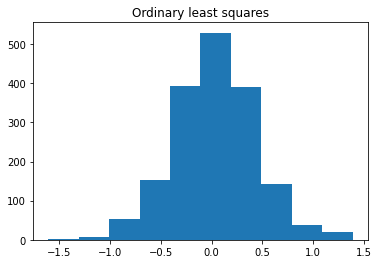

In [6]:
ols = LinearRegression()
olsfit = ols.fit(X=X_all, y=y_cont)
plt.hist(olsfit.coef_)
plt.title('Ordinary least squares')

Text(0.5, 1.0, 'Elastic net (0.5)')

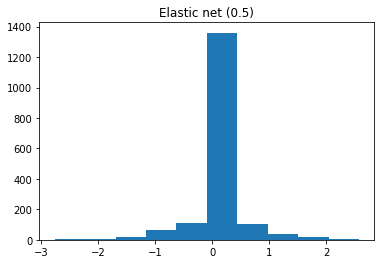

In [7]:
en = ElasticNet(tol=1e-4, max_iter=20000)
fit = en.fit(X=X_all, y=y_cont)
plt.hist(fit.coef_)
plt.title('Elastic net (0.5)')

In [8]:
fit.n_features_in_

1727

In [9]:
# enc --> "Elastic Net Coefficients"
enc = pd.DataFrame([en.coef_, data.index, data['Unique ID']]).T
enc.columns = ['coef', 'metab', 'id']
enc
enc.loc[enc['coef'].abs() > 1.3].sort_values('coef', ascending=False, key=abs)

,coef,metab,id
1177,-2.764655,m_419,unknown_271.14336_11.365
332,-2.607238,l_332,unknown_798.60071_8.686
245,2.577216,l_245,unknown_774.5647_7.996
230,-2.235743,l_230,PC_38:7_804.55353_7.784
472,2.1816,l_472,unknown_824.55579_9.735
156,-2.15502,l_156,unknown_509.33115_6.162
1203,2.025867,m_295,unknown_401.07464_11.572
715,2.025334,l_715,TG_18:1_20:5_20:5_942.75476_14.365
1184,2.006609,m_513,unknown_310.2351_11.468
1198,1.949464,m_367,unknown_85.02841_11.562


Text(0.5, 1.0, 'Lasso (L1) least squares')

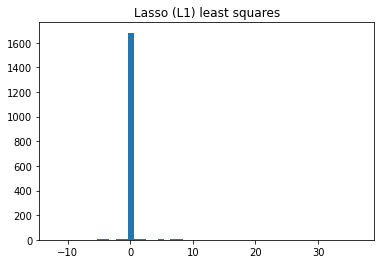

In [11]:
lasso = ElasticNet(tol=1e-4, max_iter=20000, l1_ratio=1)
lassofit = lasso.fit(X=X_all, y=y_cont)
plt.hist(lassofit.coef_, bins=50)
plt.title('Lasso (L1) least squares')

Text(0.5, 1.0, 'Ridge (L2) least squares')

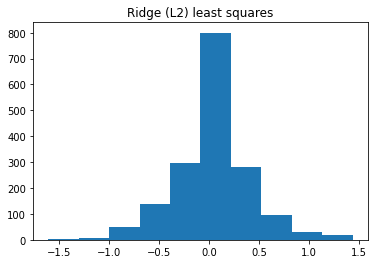

In [13]:
ridge = ElasticNet(tol=1e-4, max_iter=100000, l1_ratio=0.1)
# pure Ridge (L1 = 0) doesn't converge even for 100k iterations. 
ridgefit = ridge.fit(X=X_all, y=y_cont)
plt.hist(ridgefit.coef_)
plt.title('Ridge (L2) least squares')

## Cross-validate elastic net alpha and L1_ratio parameters

In [14]:
encv = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99], 
                    max_iter=20000,
                    cv=10,
                    n_jobs=-1,
                    random_state=1)
encvfit = encv.fit(X=X_all, y=y_cont)

In [235]:
encv.path(X=X, y=y_continuous)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.792e+02, tolerance: 1.918e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.653e+02, tolerance: 1.918e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regu

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.967e+03, tolerance: 1.918e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.440e+03, tolerance: 1.918e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regu

(array([8.51325147e+03, 7.93948682e+03, 7.40439198e+03, 6.90536074e+03,
        6.43996254e+03, 6.00593062e+03, 5.60115099e+03, 5.22365216e+03,
        4.87159549e+03, 4.54326626e+03, 4.23706532e+03, 3.95150130e+03,
        3.68518334e+03, 3.43681431e+03, 3.20518453e+03, 2.98916582e+03,
        2.78770605e+03, 2.59982399e+03, 2.42460456e+03, 2.26119432e+03,
        2.10879739e+03, 1.96667151e+03, 1.83412443e+03, 1.71051058e+03,
        1.59522789e+03, 1.48771487e+03, 1.38744787e+03, 1.29393853e+03,
        1.20673140e+03, 1.12540174e+03, 1.04955343e+03, 9.78817044e+02,
        9.12848051e+02, 8.51325147e+02, 7.93948682e+02, 7.40439198e+02,
        6.90536074e+02, 6.43996254e+02, 6.00593062e+02, 5.60115099e+02,
        5.22365216e+02, 4.87159549e+02, 4.54326626e+02, 4.23706532e+02,
        3.95150130e+02, 3.68518334e+02, 3.43681431e+02, 3.20518453e+02,
        2.98916582e+02, 2.78770605e+02, 2.59982399e+02, 2.42460456e+02,
        2.26119432e+02, 2.10879739e+02, 1.96667151e+02, 1.834124

In [16]:
encvfit.l1_ratio_

0.5

(array([2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 6.000e+00, 1.700e+01,
        2.300e+01, 4.500e+01, 4.900e+01, 9.000e+01, 1.235e+03, 9.300e+01,
        6.300e+01, 4.000e+01, 2.000e+01, 2.300e+01, 9.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00]),
 array([-2.93618429, -2.65017143, -2.36415856, -2.07814569, -1.79213283,
        -1.50611996, -1.22010709, -0.93409423, -0.64808136, -0.36206849,
        -0.07605563,  0.20995724,  0.4959701 ,  0.78198297,  1.06799584,
         1.3540087 ,  1.64002157,  1.92603444,  2.2120473 ,  2.49806017,
         2.78407304]),
 <BarContainer object of 20 artists>)

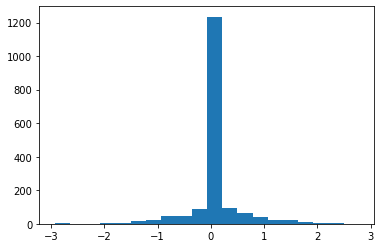

In [33]:
plt.hist(encvfit.coef_, bins=20)

In [40]:
coefs = pd.DataFrame([ols.coef_, ridgefit.coef_, lassofit.coef_, en.coef_, encvfit.coef_, 
                      data.index, data['Unique ID']]).T
coefs.columns = ['ols', 'ridge', 'lasso', 'en', 'encv', 'i', 'id']
coefs
# coefs.loc[coefs['coef'].abs() > 1.3].sort_values('coef', ascending=False, key=abs)

,ols,ridge,lasso,en,encv,i,id
0,0.32479,0.264362,0.0,0.050512,0.182307,l_0,unknown_679.05463_0.536
1,0.515974,0.38276,0.0,0.26003,0.343859,l_1,unknown_641.1087_0.537
2,0.44203,0.348676,0.0,0.0,0.020297,l_2,unknown_951.15973_0.541
3,0.399679,0.352832,0.0,0.252525,0.296149,l_3,unknown_329.03067_0.542
4,0.75366,0.748997,5.835155,1.279239,1.408392,l_4,unknown_969.13147_0.544
...,...,...,...,...,...,...,...
1722,-0.3076,-0.196838,-0.0,-0.0,-0.0,m_169,unknown_174.00102_9.94
1723,-0.087114,-0.000691,0.0,-0.0,-0.0,m_213,unknown_187.04097_9.971
1724,-0.263106,-0.188063,-0.0,-0.0,-0.0,m_24,DL-Lactic Acid_89.02331_9.99
1725,-0.194991,-0.106553,0.0,-0.0,-0.0,m_505,unknown_313.051_9.991


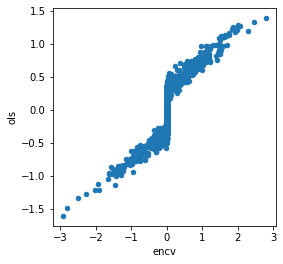

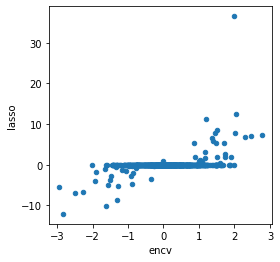

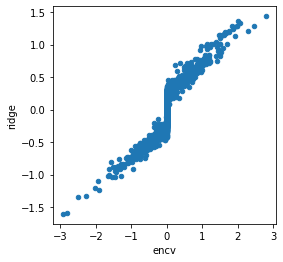

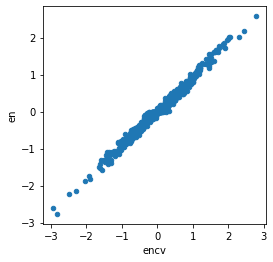

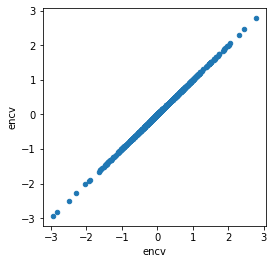

In [53]:
for m in ['ols', 'lasso', 'ridge', 'en', 'encv']: 
    coefs.plot.scatter('encv', m, figsize=(4,4))

In [55]:
coefs.sort_values('encv', key=abs, ascending=False)

,ols,ridge,lasso,en,encv,i,id
332,-1.609864,-1.606778,-5.404968,-2.607238,-2.936184,l_332,unknown_798.60071_8.686
1177,-1.485843,-1.591996,-12.10513,-2.764655,-2.829238,m_419,unknown_271.14336_11.365
245,1.39209,1.436877,7.360732,2.577216,2.784073,l_245,unknown_774.5647_7.996
230,-1.340037,-1.349551,-7.041735,-2.235743,-2.494835,l_230,PC_38:7_804.55353_7.784
472,1.336675,1.28669,7.188531,2.1816,2.458859,l_472,unknown_824.55579_9.735
...,...,...,...,...,...,...,...
924,-0.166961,-0.062656,0.0,-0.0,-0.0,l_924,unknown_938.81732_17.617
923,-0.178609,-0.093375,-0.0,-0.0,-0.0,l_923,unknown_941.82813_17.613
922,-0.16693,-0.113709,-0.0,-0.0,-0.0,l_922,unknown_921.72937_17.612
921,-0.176652,-0.072342,-0.0,-0.0,-0.0,l_921,TG_16:0_18:0_20:4_900.80231_17.608


In [66]:
coefs.loc[coefs['encv'].abs() > 0.0, ['encv', 'i', 'id']]

,encv,i,id
0,0.182307,l_0,unknown_679.05463_0.536
1,0.343859,l_1,unknown_641.1087_0.537
2,0.020297,l_2,unknown_951.15973_0.541
3,0.296149,l_3,unknown_329.03067_0.542
4,1.408392,l_4,unknown_969.13147_0.544
...,...,...,...
1696,1.166095,m_660,unknown_341.17433_9.019
1700,0.144369,m_233,unknown_212.08955_9.036
1705,0.432069,m_125,Leucine_130.08623_9.295
1715,-0.545754,m_674,unknown_243.06156_9.678


In [231]:
encvfit.mse_path_[:, :, 0][1]

array([6690.93602217, 6679.39142557, 6665.88990329, 6643.50632983,
       6614.38380174, 6574.5320175 , 6522.54823997, 6450.02134406,
       6358.72695632, 6252.87792696, 6133.34325218, 6005.92695056,
       5871.38389597, 5730.04441561, 5585.50029011, 5438.74528325,
       5290.60933044, 5144.96250868, 5004.96485673, 4872.59480039,
       4748.20977747, 4631.85147147, 4525.14339217, 4426.01255739,
       4334.80918665, 4250.83215423, 4175.66958984, 4108.50549982,
       4049.03968133, 3997.17025872, 3952.20677469, 3913.61093052,
       3877.74581235, 3844.76344463, 3815.60331939, 3790.39933817,
       3767.07132387, 3748.70812882, 3731.77628414, 3716.73344257,
       3703.85518207, 3692.04714773, 3679.96462114, 3668.92228602,
       3657.08534688, 3645.58976737, 3634.00482797, 3622.82733039,
       3611.6375193 , 3600.96835192, 3591.08197011, 3580.95290395,
       3570.63385201, 3560.96158035, 3551.65700148, 3543.5575839 ,
       3537.29235528, 3531.99891242, 3527.13878366, 3523.95789

In [39]:
exog = fg.set_index('combined_col_name')['glucose_tolerance']
exog

combined_col_name
1076_10_FBG    diabetic
1062_8_FBG     impaired
1093_9_FBG       normal
1060_8_RBG     impaired
1091_10_FBG      normal
1092_9_RBG     impaired
1093_10_RBG      normal
1082_10_FBG    diabetic
1060_9_RBG     impaired
1101_9_FBG     diabetic
1062_10_RBG    impaired
1091_8_RBG       normal
1074_10_FBG    impaired
1101_10_RBG    diabetic
1076_9_FBG     diabetic
1092_9_FBG     impaired
1074_8_FBG     impaired
1091_10_RBG      normal
1082_9_FBG     diabetic
1076_8_RBG     diabetic
1060_8_FBG     impaired
1093_9_RBG       normal
1060_10_FBG    impaired
1082_10_RBG    diabetic
1074_9_RBG     impaired
1091_9_RBG       normal
1101_10_FBG    diabetic
1093_8_FBG       normal
1074_8_RBG     impaired
1102_10_RBG    impaired
1062_9_FBG     impaired
1076_9_RBG     diabetic
1092_8_FBG     impaired
1062_10_FBG    impaired
1102_8_RBG     impaired
1074_10_RBG    impaired
1060_9_FBG     impaired
1082_9_RBG     diabetic
1076_10_RBG    diabetic
1091_9_FBG       normal
1102_9_FBG     impaire

In [36]:
endog = df.set_index('i')[data_cols].T

In [37]:
abbrev_cols = endog.columns

In [40]:
endog.join(exog)

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_1020,l_1021,l_1022,l_1023,l_1024,l_1025,l_1026,l_1027,l_1028,glucose_tolerance
1076_10_FBG,29.163795,30.152274,29.735454,29.701370,26.700629,28.721319,29.803012,29.047350,28.892166,27.170732,...,18.378388,18.336840,18.447194,16.419472,18.897008,16.810111,17.724121,18.400646,16.655211,diabetic
1062_8_FBG,30.572489,30.703658,29.569621,30.641931,21.774699,27.427681,30.349551,28.813080,28.671019,26.901321,...,17.166214,17.882779,19.507955,17.567143,19.348489,17.364343,19.240306,18.585339,16.313637,impaired
1093_9_FBG,29.753802,30.603359,30.043032,30.624242,27.051667,28.906704,30.228474,29.137348,28.609728,26.578356,...,21.175953,20.788956,21.407793,21.111930,21.529536,20.099612,21.430516,20.968101,19.339229,normal
1060_8_RBG,30.610134,29.309067,29.827946,28.459047,17.431244,29.295561,29.113441,28.848762,28.995708,22.512901,...,20.310682,19.423127,20.589383,18.430226,17.921098,18.430542,17.488155,16.202162,17.985491,impaired
1091_10_FBG,30.700893,30.505310,29.420633,30.636897,27.163433,28.470314,30.188475,28.977544,28.105805,26.149719,...,17.710758,18.448910,19.899861,18.266873,20.133479,17.986741,19.996615,19.778245,17.357845,normal
1092_9_RBG,30.577914,29.114748,29.483693,28.588431,25.867137,29.644309,29.046819,28.993620,28.339876,22.618105,...,18.375462,18.748319,19.968825,18.419951,17.824376,18.099621,17.383197,15.556400,17.582655,impaired
1093_10_RBG,30.656929,29.416945,29.886091,28.685024,26.188412,29.792770,29.130352,29.043613,28.603652,22.397004,...,18.989137,19.227975,20.089886,18.323302,18.836779,18.145468,18.282680,16.603878,17.887551,normal
1082_10_FBG,30.604336,30.081204,29.609038,30.257619,26.977695,28.204534,29.891213,28.981538,28.704319,27.005622,...,16.566651,15.513664,18.843156,15.364329,19.255315,14.496938,19.507853,19.379093,13.846921,diabetic
1060_9_RBG,30.996475,29.431175,30.018239,28.625995,26.312933,30.211206,29.212933,29.416956,29.331185,22.829664,...,19.661018,19.568500,20.581856,18.948519,18.261890,18.854601,17.718258,16.494586,18.466842,impaired
1101_9_FBG,30.672859,30.044828,29.620839,29.974868,26.709748,28.574011,29.729036,29.041379,28.488075,26.715388,...,19.419490,19.099508,20.166937,19.286479,19.685160,18.324624,19.526233,18.844052,17.739443,diabetic


In [91]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x ** 2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

X = sm.add_constant(X)
y = np.dot(X, beta) + e

X

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.01010101e-01, 1.02030405e-02],
       [1.00000000e+00, 2.02020202e-01, 4.08121620e-02],
       [1.00000000e+00, 3.03030303e-01, 9.18273646e-02],
       [1.00000000e+00, 4.04040404e-01, 1.63248648e-01],
       [1.00000000e+00, 5.05050505e-01, 2.55076013e-01],
       [1.00000000e+00, 6.06060606e-01, 3.67309458e-01],
       [1.00000000e+00, 7.07070707e-01, 4.99948985e-01],
       [1.00000000e+00, 8.08080808e-01, 6.52994592e-01],
       [1.00000000e+00, 9.09090909e-01, 8.26446281e-01],
       [1.00000000e+00, 1.01010101e+00, 1.02030405e+00],
       [1.00000000e+00, 1.11111111e+00, 1.23456790e+00],
       [1.00000000e+00, 1.21212121e+00, 1.46923783e+00],
       [1.00000000e+00, 1.31313131e+00, 1.72431385e+00],
       [1.00000000e+00, 1.41414141e+00, 1.99979594e+00],
       [1.00000000e+00, 1.51515152e+00, 2.29568411e+00],
       [1.00000000e+00, 1.61616162e+00, 2.61197837e+00],
       [1.00000000e+00, 1.71717

In [92]:
exog.values.reshape(1, -1)

array([['diabetic', 'impaired', 'normal', 'impaired', 'normal',
        'impaired', 'normal', 'diabetic', 'impaired', 'diabetic',
        'impaired', 'normal', 'impaired', 'diabetic', 'diabetic',
        'impaired', 'impaired', 'normal', 'diabetic', 'diabetic',
        'impaired', 'normal', 'impaired', 'diabetic', 'impaired',
        'normal', 'diabetic', 'normal', 'impaired', 'impaired',
        'impaired', 'diabetic', 'impaired', 'impaired', 'impaired',
        'impaired', 'impaired', 'diabetic', 'diabetic', 'normal',
        'impaired', 'impaired', 'normal', 'diabetic', 'impaired',
        'diabetic', 'impaired', 'diabetic', 'diabetic', 'normal',
        'impaired', 'diabetic', 'impaired', 'impaired', 'normal',
        'impaired', 'impaired', 'diabetic', 'impaired', 'impaired']],
      dtype=object)

In [76]:
np.asarray(exog)

array(['diabetic', 'impaired', 'normal', 'impaired', 'normal', 'impaired',
       'normal', 'diabetic', 'impaired', 'diabetic', 'impaired', 'normal',
       'impaired', 'diabetic', 'diabetic', 'impaired', 'impaired',
       'normal', 'diabetic', 'diabetic', 'impaired', 'normal', 'impaired',
       'diabetic', 'impaired', 'normal', 'diabetic', 'normal', 'impaired',
       'impaired', 'impaired', 'diabetic', 'impaired', 'impaired',
       'impaired', 'impaired', 'impaired', 'diabetic', 'diabetic',
       'normal', 'impaired', 'impaired', 'normal', 'diabetic', 'impaired',
       'diabetic', 'impaired', 'diabetic', 'diabetic', 'normal',
       'impaired', 'diabetic', 'impaired', 'impaired', 'normal',
       'impaired', 'impaired', 'diabetic', 'impaired', 'impaired'],
      dtype=object)

In [133]:
en = sm.OLS(endog=endog, exog=exog.values.reshape(1, -1)).fit_regularized(L1_wt=0.5)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [126]:
formula

'C(glucose_tolerance) ~ m_0 + m_1 + m_2 + m_3 + m_4 + m_5 + m_6 + m_7 + m_8 + m_9 + m_10 + m_11 + m_12 + m_13 + m_14 + m_15 + m_16 + m_17 + m_18 + m_19 + m_20 + m_21 + m_22 + m_23 + m_24 + m_25 + m_26 + m_27 + m_28 + m_29 + m_30 + m_31 + m_32 + m_33 + m_34 + m_35 + m_36 + m_37 + m_38 + m_39 + m_40 + m_41 + m_42 + m_43 + m_44 + m_45 + m_46 + m_47 + m_48 + m_49 + m_50 + m_51 + m_52 + m_53 + m_54 + m_55 + m_56 + m_57 + m_58 + m_59 + m_60 + m_61 + m_62 + m_63 + m_64 + m_65 + m_66 + m_67 + m_68 + m_69 + m_70 + m_71 + m_72 + m_73 + m_74 + m_75 + m_76 + m_77 + m_78 + m_79 + m_80 + m_81 + m_82 + m_83 + m_84 + m_85 + m_86 + m_87 + m_88 + m_89 + m_90 + m_91 + m_92 + m_93 + m_94 + m_95 + m_96 + m_97 + m_98 + m_99 + m_100 + m_101 + m_102 + m_103 + m_104 + m_105 + m_106 + m_107 + m_108 + m_109 + m_110 + m_111 + m_112 + m_113 + m_114 + m_115 + m_116 + m_117 + m_118 + m_119 + m_120 + m_121 + m_122 + m_123 + m_124 + m_125 + m_126 + m_127 + m_128 + m_129 + m_130 + m_131 + m_132 + m_133 + m_134 + m_135 

In [132]:
formula = "glucose_tolerance ~ "  # +  "m_0 + m_1 + m_2"
for metab in abbrev_cols:
    formula += str(metab) + ' + '
formula = formula[:-10001]

en = smf.ols(formula=formula, data=endog.join(exog)).fit_regularized(L1_wt=0.5)    #.fit_regularized(L1_wt=0.5)   # family=sm.families.Binomial()

ValueError: operands could not be broadcast together with shapes (60,3) (60,) 

In [68]:
from numpy.distutils.system_info import get_info
print(get_info('blas_opt'))
print(get_info('lapack_opt'))

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl
Could not locate executable gfortran
Could not locate executable f95
Could not locate executable g95
Could not locate executable efort
Could not locate executable efc
Could not locate executable flang
don't know how to compile Fortran code on platform 'nt'
{}
{}


C:\Users\ben\Anaconda3\lib\site-packages\numpy\distutils\system_info.py:2026: UserWarning: 
    Optimized (vendor) Blas libraries are not found.
    Falls back to netlib Blas library which has worse performance.
    A better performance should be easily gained by switching
    Blas library.
  if self._calc_info(blas):
C:\Users\ben\Anaconda3\lib\site-packages\numpy\distutils\system_info.py:2026: UserWarning: 
    Blas (http://www.netlib.org/blas/) libraries not found.
    Directories to search for the libraries can be specified in the
    numpy/distutils/site.cfg file (section [blas]) or by setting
    the BLAS environment variable.
  if self._calc_info(blas):
C:\Users\ben\Anaconda3\lib\site-packages\numpy\distutils\system_info.py:2026: UserWarning: 
    Blas (http://www.netlib.org/blas/) sources not found.
    Directories to search for the sources can be specified in the
    numpy/distutils/site.cfg file (section [blas_src]) or by setting
    the BLAS_SRC environment variable.
  if sel